### Визначення границь та кутів у зображенні за допомогою фільтра Собеля

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy import ravel
from google.colab.patches import cv2_imshow


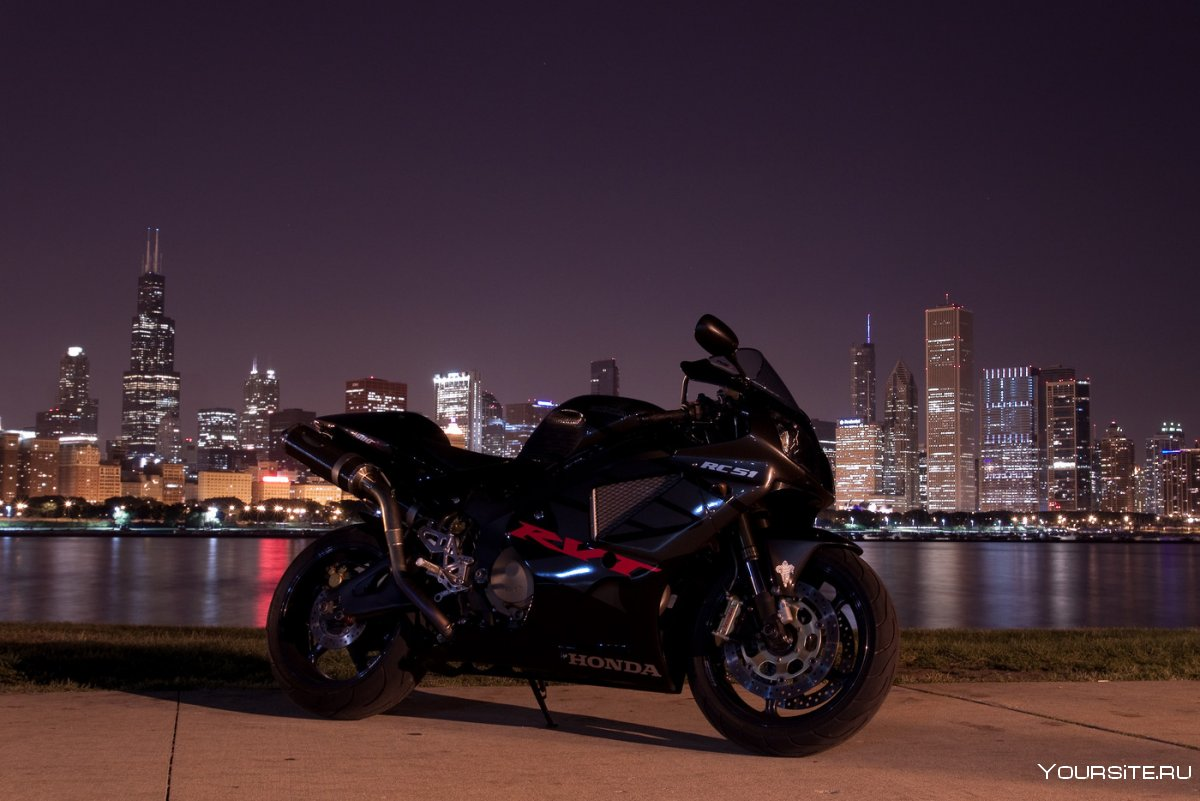

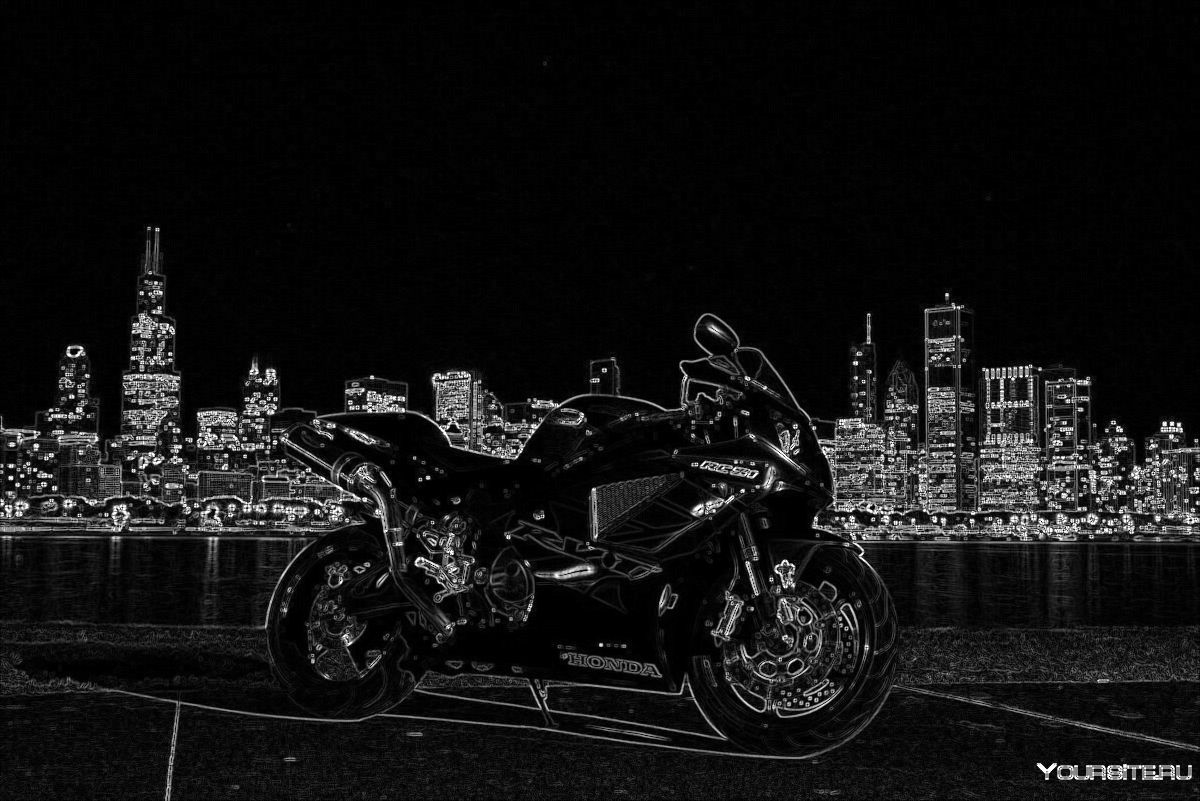

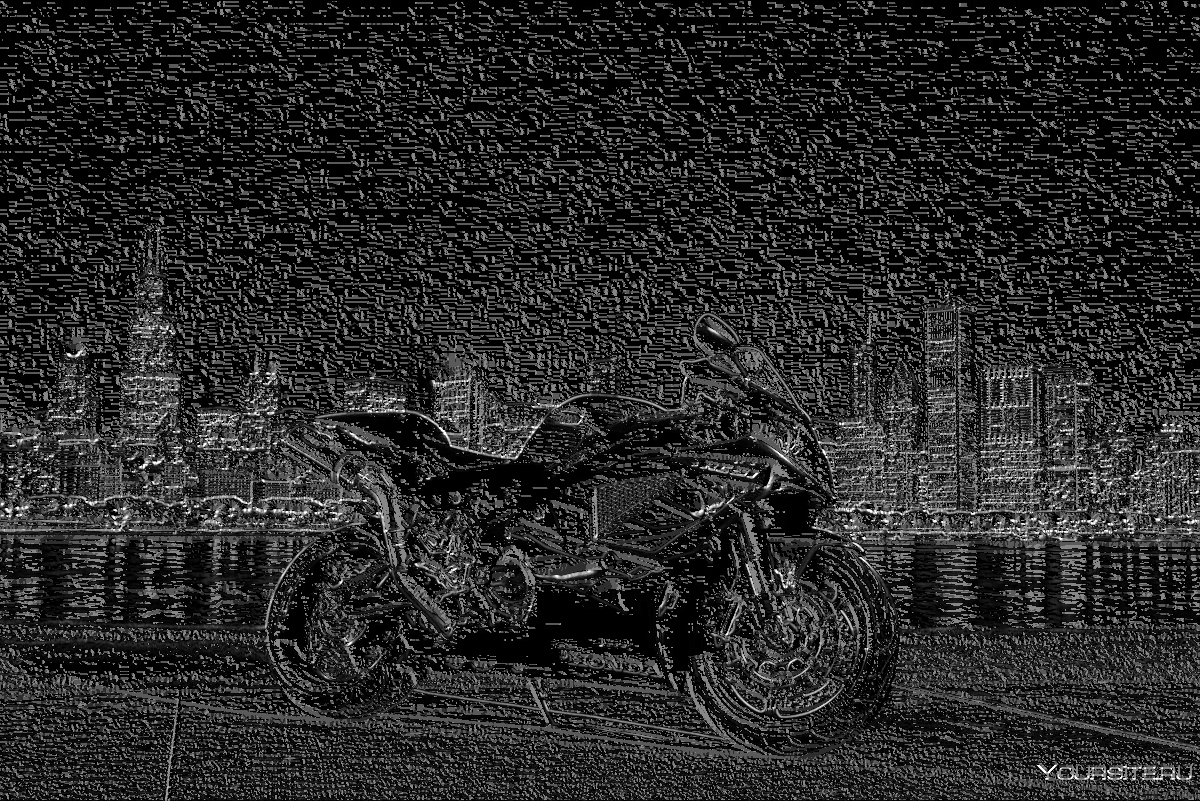

True

In [10]:
# Завантаження зображення та конвертування до відтінків сірого
img = cv2.imread('moto.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Обчислення горизонтальних та вертикальних градієнтів зображення
grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

# Визначення модуля та напрямку градієнтів
abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
angle = cv2.phase(grad_x, grad_y, angleInDegrees=True)

# Відображення зображення та границь
cv2_imshow(img)
cv2_imshow(grad)

cv2.imwrite('Edges.jpg', grad)

# Відображення кутів на зображенні
for i in range(grad.shape[0]):
    for j in range(grad.shape[1]):
        if angle[i,j] > 0 and angle[i,j] < 45:
            grad[i,j] = 0
        elif angle[i,j] >= 45 and angle[i,j] < 90:
            grad[i,j] = 45
        elif angle[i,j] >= 90 and angle[i,j] < 135:
            grad[i,j] = 90
        elif angle[i,j] >= 135 and angle[i,j] < 180:
            grad[i,j] = 135
cv2_imshow(grad)

cv2.imwrite('Edges with moto.jpg', grad)

### Метод густини градієнта (HOG) для витягування ознак з зображення

In [14]:
from skimage.feature import hog
from skimage import data, exposure

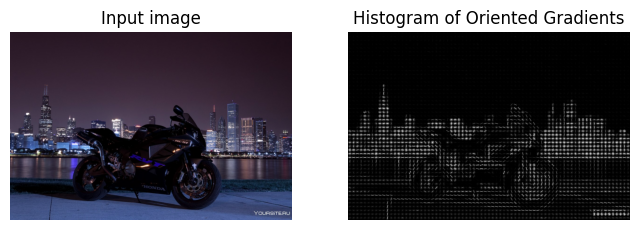

In [15]:
img = cv2.imread('moto.jpg')

fd, hog_img = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_img_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_img_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

### CIFAR_10 (HOG)

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.feature import hog
from skimage import color
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import PCA
import numpy as np

In [17]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [18]:
train_data_gray = np.array([cv2.cvtColor(x.reshape(32, 32, 3), cv2.COLOR_BGR2GRAY) for x in x_train])
test_data_gray = np.array([cv2.cvtColor(x.reshape(32, 32, 3), cv2.COLOR_BGR2GRAY) for x in x_test])


In [19]:
train_hog_features = np.array([hog(x, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False) for x in train_data_gray])
test_hog_features = np.array([hog(x, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False) for x in test_data_gray])


In [20]:
pca = PCA(n_components=200, random_state=42)
train_pca_features = pca.fit_transform(train_hog_features)
test_pca_features = pca.transform(test_hog_features)


In [21]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [22]:
clf = SVC(kernel='rbf')
clf.fit(train_pca_features, y_train)


SVC()

In [23]:
y_pred = clf.predict(test_pca_features)

In [24]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1-Score:', f1)

Accuracy: 0.626
Precision: 0.6249679364491738
Recall: 0.626
F1-Score: 0.6246989635968799


### SIFT

In [25]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [26]:
x_train_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in x_train])
x_test_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in x_test])

In [27]:
sift = cv2.SIFT_create()

In [28]:
sift_train_features = []
sift_train_labels = []
for i in range(len(x_train_gray)):
    keypoints, descriptors = sift.detectAndCompute(x_train_gray[i], None)
    if descriptors is not None:
        sift_train_features.append(descriptors)
        sift_train_labels.append(y_train[i])

In [29]:
sift_test_features = []
sift_test_labels = []
for i in range(len(x_test_gray)):
    keypoints, descriptors = sift.detectAndCompute(x_test_gray[i], None)
    if descriptors is not None:
        sift_test_features.append(descriptors)
        sift_test_labels.append(y_test[i])

In [30]:
max_descriptors = max([len(desc) for desc in sift_train_features])
sift_train_features_arr = np.zeros((len(sift_train_features), max_descriptors, 128))
for i in range(len(sift_train_features)):
    for j in range(len(sift_train_features[i])):
        sift_train_features_arr[i][j] = sift_train_features[i][j]

In [31]:
max_descriptors = max([len(desc) for desc in sift_test_features])
sift_test_features_arr = np.zeros((len(sift_test_features), max_descriptors, 128))
for i in range(len(sift_test_features)):
    for j in range(len(sift_test_features[i])):
        sift_test_features_arr[i][j] = sift_test_features[i][j]

In [32]:
new_sift_train_features_arr = sift_train_features_arr.reshape(len(sift_train_features_arr), -1)
new_sift_test_features_arr = sift_test_features_arr.reshape(len(sift_test_features_arr), -1)

In [33]:
pca = PCA(n_components=200)
train_pca_features_shift = pca.fit_transform(new_sift_train_features_arr)
test_pca_features_shift = pca.fit_transform(new_sift_test_features_arr)

In [34]:
new_sift_train_labels = []
for i in sift_train_labels:
  new_sift_train_labels.append(i[0])

In [35]:
new_sift_test_labels = []
for i in sift_test_labels:
  new_sift_test_labels.append(i[0])

In [36]:
clf = SVC(kernel='rbf')
clf.fit(train_pca_features_shift, new_sift_train_labels)

SVC()

In [37]:
y_pred = clf.predict(test_pca_features_shift)

In [ ]:
accuracy = accuracy_score(new_sift_test_labels, y_pred)
precision = precision_score(new_sift_test_labels, y_pred, average='macro')
recall = recall_score(new_sift_test_labels, y_pred, average='macro')
f1 = f1_score(new_sift_test_labels, y_pred, average='macro')


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.1904570970328789
Precision: 0.18823086903631206
Recall: 0.19054934408495355
F1-score: 0.18815537812832236


### Висновок

Згідно метрик точності, для класифікації за допомогою SVM даних датасету CIFAR-10 виявився більш точним HOG метод для витягування ознак з зображення.